# 1. Import and Install Dependencies

In [1]:
!pip install tensorflow==2.10.1 tensorflow-gpu==2.10.1 tensorflow-io==0.27 matplotlib

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [3]:
gpus=tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Build Data Loading Function

In [4]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [5]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [6]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

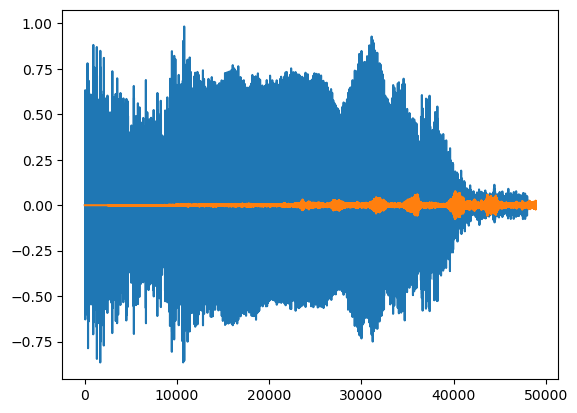

In [7]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

In [8]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [9]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [10]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

In [11]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [12]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [13]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [14]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

In [15]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [16]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [17]:
spectrogram, label = preprocess(filepath, label)

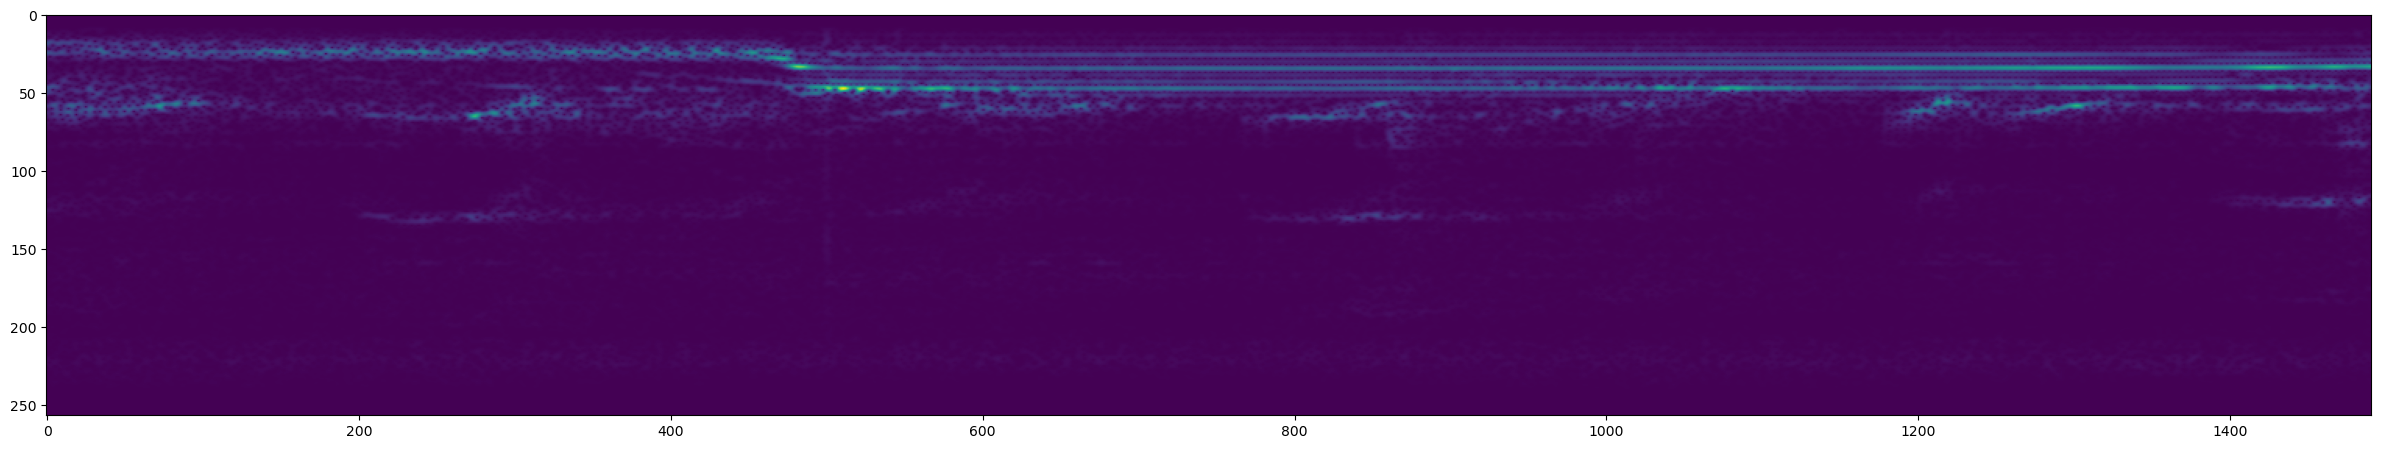

In [18]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

In [19]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [20]:
train = data.take(36)
test = data.skip(36).take(15)

In [21]:
samples, labels = train.as_numpy_iterator().next()

In [22]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

In [23]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten,MaxPooling2D,Activation

In [24]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, MaxPool2D,AveragePooling2D
# from keras.layers import Activation, Dropout, Flatten, Dense

In [25]:
# model = Sequential()
# model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
# model.add(Conv2D(16, (3,3), activation='relu'))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [26]:
model=Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(1491, 257,1)))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(42,(3,3),activation='relu'))
# # model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16,(3,3),activation='relu'))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
# model.add(activation('sigmoid'))

In [27]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 16)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 368032)            0         
                                                                 
 dense (Dense)               (None, 128)               4

In [29]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 17s 230ms/step - loss: 0.8483 - recall: 0.8910 - precision: 0.8129 - val_loss: 0.0071 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 2/4
36/36 [==============================] - 7s 208ms/step - loss: 0.0178 - recall: 0.9937 - precision: 0.9876 - val_loss: 0.0160 - val_recall: 0.9853 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 7s 207ms/step - loss: 0.0069 - recall: 0.9935 - precision: 1.0000 - val_loss: 0.0439 - val_recall: 1.0000 - val_precision: 0.9846
Epoch 4/4
36/36 [==============================] - 7s 208ms/step - loss: 0.0338 - recall: 1.0000 - precision: 0.9933 - val_loss: 8.5542e-04 - val_recall: 1.0000 - val_precision: 1.0000


In [30]:
model.save("BirdCount.h5")

In [ ]:
model=load_model("BirdCount.h5")

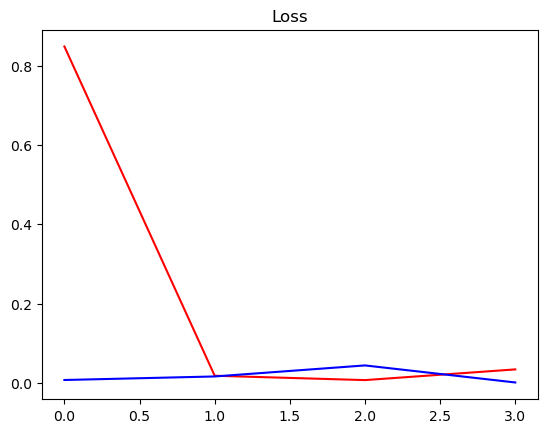

In [31]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

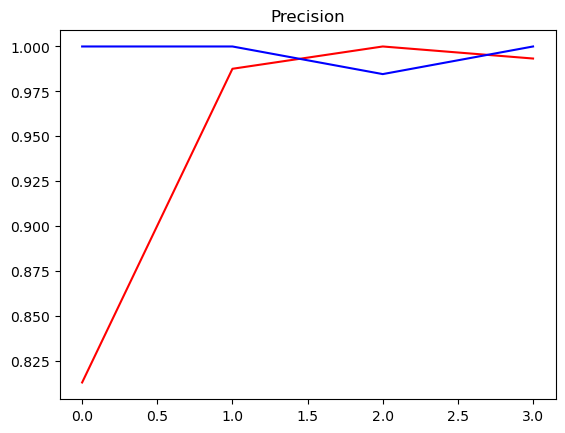

In [32]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

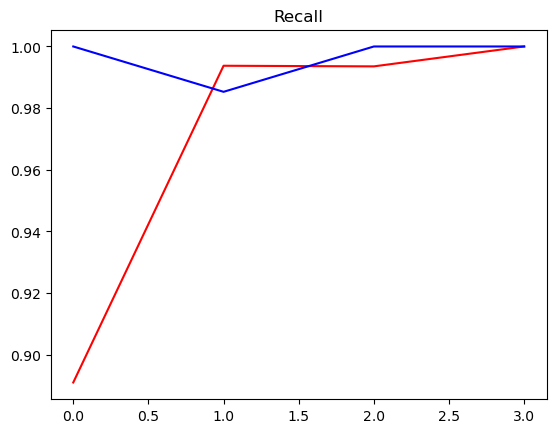

In [33]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

In [34]:
X_test, y_test = test.as_numpy_iterator().next()

In [35]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 146ms/step


In [36]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [37]:
yhat

[1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

# 9. Build Forest Parsing Functions

In [38]:
def load_mp3_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [39]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [40]:
wav = load_mp3_16k_mono(mp3)

In [41]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [42]:
samples, index = audio_slices.as_numpy_iterator().next()

In [43]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [44]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(32)

In [45]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

6/6 [==============================] - 2s 175ms/step


In [46]:
from itertools import groupby

In [47]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [48]:
calls

5

# 10. Make Predictions

In [49]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(32)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

2/2 [==============================] - 1s 155ms/step


In [50]:
results

{'recording_00.mp3': array([[4.3297913e-03],
        [1.5462638e-02],
        [3.1666983e-02],
        [7.6092422e-01],
        [1.0000000e+00],
        [5.6497165e-04],
        [4.3298574e-03],
        [1.8132301e-02],
        [4.0873089e-03],
        [1.7088193e-02],
        [1.3739303e-02],
        [7.3711514e-03],
        [4.0662815e-03],
        [9.9991524e-01],
        [1.0000000e+00],
        [2.2478322e-03],
        [4.7052109e-07],
        [3.4609637e-03],
        [6.9789244e-03],
        [2.7108494e-02],
        [1.1466731e-02],
        [6.1358442e-03],
        [4.3613009e-02],
        [7.4716556e-01],
        [1.0000000e+00],
        [7.0590794e-04],
        [9.4591017e-04],
        [1.4416810e-02],
        [6.6869068e-03],
        [2.4329025e-02],
        [4.1676750e-03],
        [2.1560386e-02],
        [3.4554272e-03],
        [3.1171346e-04],
        [2.6018098e-02],
        [3.7870475e-03],
        [1.0000000e+00],
        [5.7301336e-06],
        [3.0527439e-02],
     

In [51]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [52]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 22,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 4,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 6,
 'recording_17.mp3': 10,
 'recording_18.mp3': 0,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 6,
 'recording_24.mp3': 0,
 'recording_25.mp3': 9,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 11,
 'recording_29.mp3': 0,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 9,
 'recording_39.mp3': 5,
 'recording_40.mp3': 1,
 'recording_4

# 11. Export Results

In [53]:
import csv

In [54]:
with open('AudioCounts.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])